In [11]:
import numpy as np
from netCDF4 import Dataset

N = 1440  # 每个 face 的边长
faces = 6

def cubed_sphere_face_coords(N):
    """生成单面 cubed-sphere 坐标 (x, y) 在 [-1,1]"""
    i = np.arange(N)
    j = np.arange(N)
    x = (2*i + 1)/N - 1
    y = (2*j + 1)/N - 1
    xx, yy = np.meshgrid(x, y, indexing='ij')
    return xx, yy

def xyz_to_lonlat(x, y, face):
    """gnomonic cubed-sphere -> lon/lat"""
    import math
    # 简单映射，6 个 face 的方向系数
    if face == 0:
        X, Y, Z = 1, x, -y
    elif face == 1:
        X, Y, Z = -x, 1, -y
    elif face == 2:
        X, Y, Z = -1, -x, -y
    elif face == 3:
        X, Y, Z = x, -1, -y
    elif face == 4:
        X, Y, Z = y, x, 1
    elif face == 5:
        X, Y, Z = -y, x, -1
    lon = np.arctan2(Y, X) * 180/np.pi
    lat = np.arctan2(Z, np.sqrt(X**2 + Y**2)) * 180/np.pi
    return lon, lat

# 创建 NetCDF
nc = Dataset("grid.nc", "w")
nc.createDimension("face", faces)
nc.createDimension("y", N)
nc.createDimension("x", N)

lon_var = nc.createVariable("lon", "f8", ("face","y","x"))
lat_var = nc.createVariable("lat", "f8", ("face","y","x"))

for face in range(faces):
    x, y = cubed_sphere_face_coords(N)
    lon, lat = xyz_to_lonlat(x, y, face)
    lon_var[face,:,:] = lon
    lat_var[face,:,:] = lat

nc.close()
print("生成完成：grid.nc")


生成完成：grid.nc


In [12]:
import numpy as np

# C1440 网格参数
N = 1440  # 每个 face 边长

def cubed_sphere_face_coords(N):
    """生成单面 cubed-sphere 局部坐标 x,y ∈ [-1,1]"""
    i = np.arange(N)
    j = np.arange(N)
    x = (2*i + 1)/N - 1
    y = (2*j + 1)/N - 1
    return x, y

def cubed_sphere_index_to_lonlat(face, i, j, N=1440):
    """
    将 cubed-sphere 索引 (face, i, j) 转为 (lon, lat)
    face: 0~5
    i, j: 0~N-1
    """
    # 单面局部坐标
    xi = (2*i + 1)/N - 1
    eta = (2*j + 1)/N - 1
    
    # gnomonic cubed-sphere -> xyz
    if face == 0:
        X, Y, Z = 1.0, xi, -eta
    elif face == 1:
        X, Y, Z = -xi, 1.0, -eta
    elif face == 2:
        X, Y, Z = -1.0, -xi, -eta
    elif face == 3:
        X, Y, Z = xi, -1.0, -eta
    elif face == 4:
        X, Y, Z = eta, xi, 1.0
    elif face == 5:
        X, Y, Z = -eta, xi, -1.0
    else:
        raise ValueError("face 必须是 0~5")
    
    # xyz -> lon/lat (弧度 -> 度)
    lon = np.arctan2(Y, X) * 180.0 / np.pi
    lat = np.arctan2(Z, np.sqrt(X**2 + Y**2)) * 180.0 / np.pi
    
    return lon, lat


In [13]:
# 示例：face 0, i=100, j=200
lon, lat = cubed_sphere_index_to_lonlat(face=0, i=100, j=200)
print(f"lon = {lon:.4f}, lat = {lat:.4f}")


lon = -40.7093, lat = 28.6760


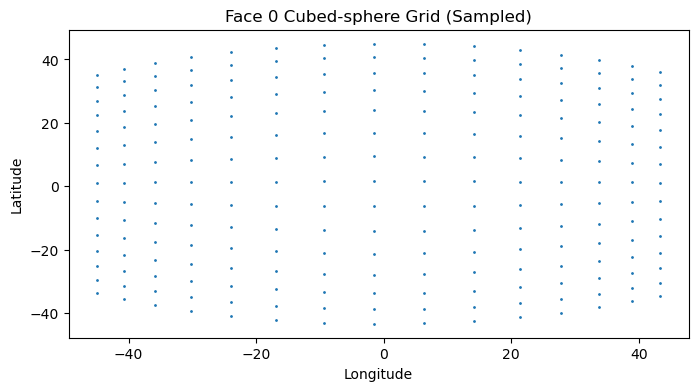

In [14]:
import matplotlib.pyplot as plt
import numpy as np

N = 1440
i = np.arange(N)
j = np.arange(N)
ii, jj = np.meshgrid(i, j, indexing='ij')

# 调用函数生成经纬度
lon_grid, lat_grid = cubed_sphere_index_to_lonlat(face=0, i=ii, j=jj)

plt.figure(figsize=(8,4))
plt.scatter(lon_grid[::100, ::100], lat_grid[::100, ::100], s=1)
plt.title("Face 0 Cubed-sphere Grid (Sampled)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


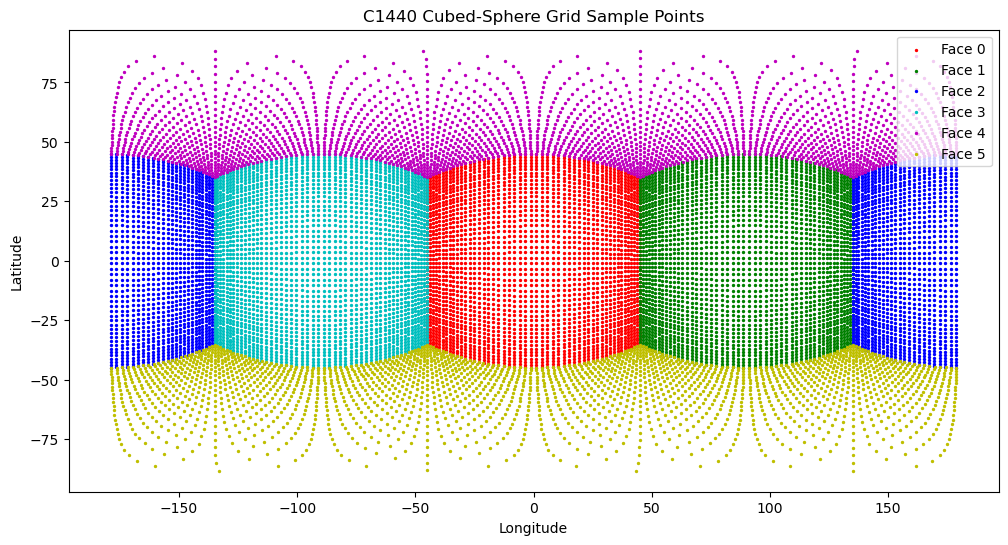

Face 4, i=559, j=1216 -> lon=-17.9141, lat=54.0685
Face 3, i=763, j=1383 -> lon=-86.5426, lat=-42.6094
Face 1, i=277, j=599 -> lon=58.4258, lat=8.1148
Face 0, i=600, j=1420 -> lon=-9.4236, lat=-43.8245
Face 2, i=705, j=551 -> lon=178.8463, lat=13.1692


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# C1440 网格参数
N = 1440
faces = 6

# cubed-sphere 索引 -> lon/lat 函数
def cubed_sphere_index_to_lonlat(face, i, j, N=1440):
    xi = (2*i + 1)/N - 1
    eta = (2*j + 1)/N - 1
    if face == 0:
        X, Y, Z = 1.0, xi, -eta
    elif face == 1:
        X, Y, Z = -xi, 1.0, -eta
    elif face == 2:
        X, Y, Z = -1.0, -xi, -eta
    elif face == 3:
        X, Y, Z = xi, -1.0, -eta
    elif face == 4:
        X, Y, Z = eta, xi, 1.0
    elif face == 5:
        X, Y, Z = -eta, xi, -1.0
    else:
        raise ValueError("face 必须是 0~5")
    lon = np.arctan2(Y, X) * 180.0 / np.pi
    lat = np.arctan2(Z, np.sqrt(X**2 + Y**2)) * 180.0 / np.pi
    return lon, lat

# 可视化采样点
plt.figure(figsize=(12,6))
colors = ['r','g','b','c','m','y']

for face in range(faces):
    # 采样每面 50×50 个点
    sample = 50
    i_s = np.linspace(0, N-1, sample).astype(int)
    j_s = np.linspace(0, N-1, sample).astype(int)
    ii, jj = np.meshgrid(i_s, j_s, indexing='ij')
    lon_grid, lat_grid = cubed_sphere_index_to_lonlat(face, ii, jj)
    plt.scatter(lon_grid.flatten(), lat_grid.flatten(), s=2, c=colors[face], label=f'Face {face}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('C1440 Cubed-Sphere Grid Sample Points')
plt.legend()
plt.show()

# 随机 spot check
np.random.seed(0)
for _ in range(5):
    face = np.random.randint(0,6)
    i = np.random.randint(0,N)
    j = np.random.randint(0,N)
    lon, lat = cubed_sphere_index_to_lonlat(face, i, j)
    print(f"Face {face}, i={i}, j={j} -> lon={lon:.4f}, lat={lat:.4f}")
